<a href="https://colab.research.google.com/github/Mathew057/CS-6301-CNNs/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries/Config

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sat Apr 11 03:03:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

#Hyperparameters

In [0]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# training
BATCH_SIZE      = 32
SHUFFLE_BUFFER  = 5000

TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001

TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 25

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

#Load Datasets

In [3]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# download data and split into training and testing datasets
dataset_train = tfds.load("cifar10", split=tfds.Split.TRAIN)

# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=AUTOTUNE)
dataset_train = dataset_train.shuffle(buffer_size=SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(AUTOTUNE)


dataset_test = tfds.load("cifar10", split=tfds.Split.TEST)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(AUTOTUNE)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteCFZ3K9/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteCFZ3K9/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


#Setup Model

In [4]:
# create and compile model
def create_model(img_height, img_width, channels, num_classes, lr_initial):
  model = keras.Sequential([
      Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channels,)),
      MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      BatchNormalization(),
      Conv2D(96, (3,3), activation='relu', padding='same'),
      MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
      BatchNormalization(),
      Conv2D(192, (3,3), activation='relu', padding='same'),
      Conv2D(192, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
      
      Flatten(),
      Dense(512, activation = 'relu'),
      Dropout(0.5),
      
      Dense(256, activation = 'relu'),
      Dropout(0.5),
      
      Dense(num_classes, activation = 'softmax')
  ], name="AlexNet")
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_initial, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


# create and compile model
model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, DATA_NUM_CLASSES, TRAINING_LR_MAX)

# model description and figure
model.summary()
# keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 48)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 48)          192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 96)          41568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         1660

#Train

In [5]:
# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL
    return lr

# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# training
initial_epoch_num = 0
history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 2.3475 - accuracy: 0.1032
Epoch 00001: val_loss improved from inf to 2.29433, saving model to ./save/model/model_1.h5
1563/1563 [==============================] - 20s 13ms/step - loss: 2.3475 - accuracy: 0.1032 - val_loss: 2.2943 - val_accuracy: 0.1057 - lr: 1.0000e-05
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 2.1697 - accuracy: 0.1838
Epoch 00002: val_loss improved from 2.29433 to 1.87946, saving model to ./save/model/model_2.h5
1563/1563 [==============================] - 20s 13ms/step - loss: 2.1697 - accuracy: 0.1838 - val_loss: 1.8795 - val_accuracy: 0.3229 - lr: 2.0800e-04
Epoch 3/30
1557/1563 [============================>.] - ETA: 0s - loss: 1.7963 - accuracy: 0.3200
Epoch 00003: val_loss improved from 1.87946 to 1.50268, saving model to ./save/model/model_3.h5
1563/1563 [==============================] - 20s 13ms/step - loss: 1.7961 - accuracy: 0.3201 - val_loss: 1.5027 - val_

#Plot

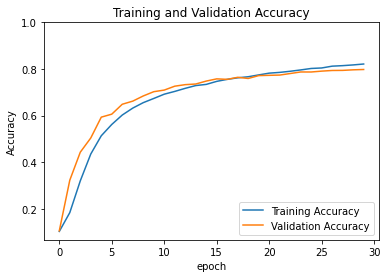

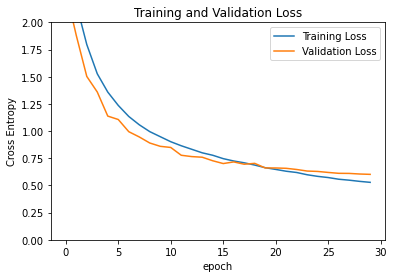

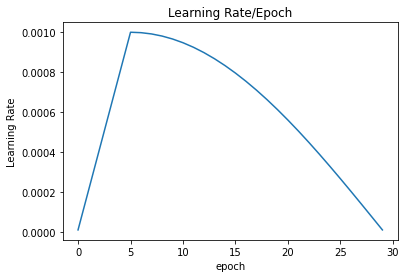

In [6]:
# training and validation data accuracy
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

# training and validation data loss
loss     = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.plot([lr_schedule(epoch) for epoch in range(TRAINING_NUM_EPOCHS)])
plt.ylabel('Learning Rate')
plt.xlabel('epoch')
plt.title("Learning Rate/Epoch")
plt.show()